# 공공데이터를 활용한 고객 성향 분석

* https://adstat.kobaco.co.kr/mcr/portal/dataSet/mdssListPage.do

* 2018년 소비자행태조사 원시데이터 - 2018년 이전의 데이터 또한 존재하지만 최근의 데이터를 이용했고, 년도별 엑셀파일에는 4000명의 설문지 결과 데이터가 저장되어 있다. 수 많은 항목에 대한 설문 결과가 있기 때문에 분석 목적에 맞는 정보를 선별하여 이용할 수 있다. 데이터 분석을 통해서 고객의 일반적인 성향을 파악하고 마케팅에 활용할 수 있다.

* 이번 분석에서는 크게 두 부분으로 나눠서 분석을 해보고 최종 결론을 내리는 것을 목표로 한다. 모델링을 통한 기계학습 보다는 사실 확인, 인사이트 발견이 목적이다. 첫번 째는 특정 연령대를 대상으로 마케팅을 하고자 할때 어떤 매체를 통해서 어떤 시간대에 광고를 하는 것이 가장 적절한지를 알아보는 것이고, 두번 째는 각종 매체의 광고에 대한 고객의 만족도를 분석하고 어떤 마케팅 전략을 펼치면 좋을지 분석해 본다. 

# Analysis 1
특정 연령대를 대상으로 마케팅을 하고자 할 때, 어떤 매체를 통해서 어떤 시간대에 광고를 하는 것이 가장 적절할까?

## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
import pickle
from collections import defaultdict

rc('font', family= 'LG PC')
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.options.display.max_rows = 4000

In [2]:
# answer = pd.read_excel('MCR2018.xlsx', sheet_name='답변정보')
# problem = pd.read_excel('MCR2018.xlsx', sheet_name='문항정보')
# example = pd.read_excel('MCR2018.xlsx', sheet_name='보기정보')

In [3]:
# dataset = [answer, problem, example]
# with open('dataset.pickle', 'wb') as fw:
#     pickle.dump(dataset, fw)

* __Note:__ 데이터를 불러오는데 많은 시간이 걸린다. 피클로 DataFrame을 binary하게 저장해둔 후에 빨리 불러올 수 있도록 하였다. 

In [4]:
with open('dataset.pickle', 'rb') as fr:
    read = pickle.load(fr)

In [5]:
answer = read[0]
problem = read[1]
example = read[2]

## Preprocessing

* __Note:__ 시간대별 이용매체에 대한 설문결과를 이용하여 사용자의 연령, 성별등과 어떤 관계가 있는지 알아본다.

In [6]:
problem.head(10)

,항목ID,항목명,데이터타입,설문 문항
0,YEAR,조사년도,단수,<없음>
1,A_001,성별,단수,귀하의 성별은 무엇입니까?
2,A_002,연령(10대),단수,귀하의 연령은 무엇입니까?
3,A_003,연령(1세),주관식,귀하의 연령은 무엇입니까?
4,A_004,지역(권역),단수,현재 거주하고 계신 지역은 어디인가요?
5,A_006,직업,단수,귀하의 직업은 무엇입니까?
6,A_007,가구 월평균 소득(1),단수,귀댁의 월평균 소득은 얼마나 됩니까?
7,A_009,본인 월평균 소득(1),단수,귀하 본인의 월 평균 소득은 얼마입니까?
8,A_011,한 달 평균 지출액 (신용카드+체크카드),단수,귀하께서는 한 달 평균 신용카드와 체크카드를 합쳐서 얼마 정도 사용하시나요? 주 사...
9,A_013,최종학력,단수,귀하의 최종 학력은 어떻게 되십니까?


In [7]:
problem.loc[problem['항목명'].str.contains('시대 이용매체')].head()

,항목ID,항목명,데이터타입,설문 문항
52,B_04_001#1,1시대 이용매체,복수,귀하께서 어제 1시대에 이용하신 매체를 모두 말씀해 주십시오
53,B_04_001#2,1시대 이용매체,복수,귀하께서 어제 1시대에 이용하신 매체를 모두 말씀해 주십시오
54,B_04_001#3,1시대 이용매체,복수,귀하께서 어제 1시대에 이용하신 매체를 모두 말씀해 주십시오
55,B_04_001#4,1시대 이용매체,복수,귀하께서 어제 1시대에 이용하신 매체를 모두 말씀해 주십시오
56,B_04_001#5,1시대 이용매체,복수,귀하께서 어제 1시대에 이용하신 매체를 모두 말씀해 주십시오


* __Note:__ 설문 항목별로 가능한 답안을 dictionary 형태로 저장해 놓았다.

In [8]:
example = example.fillna(method='ffill')

In [9]:
example.head(5)

,항목ID,항목코드,항목코드명
0,YEAR,2001,2001년
1,YEAR,2002,2002년
2,YEAR,2003,2003년
3,YEAR,2004,2004년
4,YEAR,2005,2005년


In [10]:
example_dict = defaultdict(dict)
for _, row in example.iterrows():
    example_dict[row['항목ID']][row['항목코드']] = row['항목코드명']

* __Note:__ 가능한 매체의 종류

In [11]:
example_dict['B_04_024#1']

{1: '지상파 채널',
 2: '종합편성 채널',
 3: '케이블 채널',
 4: 'VOD',
 5: '라디오',
 6: 'DMB',
 7: 'PC 인터넷',
 8: '모바일 인터넷',
 9: '신문',
 10: '잡지',
 51: 'TV',
 52: '케이블 채널(종편 포함)',
 53: '스카이라이프',
 54: 'IPTV',
 55: '스마트기기 TV시청어플',
 99: '이용하지 않음'}

* __Note:__ 시간대별 이용매체 조사 설문은 10개까지 복수응답이 가능하다. 복수응답을 모두 끌어모아 유저별 시간대별 이용매체의 DataFrame형태로 정리한 뒤에 성별, 나이의 정보를 담은 DataFrame과 join시켜 최종 DataSet을 완성한다.

In [12]:
def user_time_media_df():
    col = 'B_04_001#1'
    result_list = []
    result_dict = defaultdict(list)
    for i in range(1, 25):
        for j in range(1, 11):
            if i < 10:
                col_str = col[:7] + '{}' + col[8:-1] + '{}'
            else:
                col_str = col[:6] + '{}' + col[8:-1] + '{}'
            result_list.append(col_str.format(i, j))
        count = 1
        for _, rows in answer[result_list].iterrows():
            user_col = 'user{}'.format(count)
            each_row = rows.replace(' ', np.nan)
            each_row = each_row.dropna()
            for k in each_row.tolist():
                result_dict['고객'].append(user_col)
                result_dict['시간대'].append(i)
                result_dict['이용매체'].append(k)
            count += 1
        result_list = []
    result_df = pd.DataFrame(result_dict)
    return result_df

def user_gender_age_df():
    col = ['A_001', 'A_002', 'A_003']
    result_df = answer[col]
    result_df.columns = ['성별', '나이대', '나이']
    result_df['고객'] = result_df.index
    result_df['고객'] = result_df['고객'].apply(lambda x: 'user{}'.format(x+1))
    return result_df

def cat_transform(x, problem):
    exdict = example_dict[problem]
    for key in exdict.keys():
        if int(x) == key:            
            return str.lstrip(exdict[key])
    return 'error'

In [13]:
media_df = user_time_media_df()

In [14]:
char_df = user_gender_age_df()

In [15]:
merge_df = pd.merge(media_df, char_df, how='inner', left_on='고객', right_on='고객')

In [16]:
merge_df['성별'] = merge_df['성별'].apply(cat_transform, args=('A_001',))
merge_df['이용매체'] = merge_df['이용매체'].apply(cat_transform, args=('B_04_001#1',))
merge_df['나이대'] = merge_df['나이대'].apply(cat_transform, args=('A_002',))

In [17]:
merge_df = merge_df[merge_df['이용매체'] != '이용하지 않음']
merge_df.reset_index(inplace=True)
merge_df.drop(['index'], axis=1, inplace=True)

## Visualization

In [18]:
merge_df_1 = merge_df.copy()
merge_df_1.drop(['나이'], axis=1, inplace=True)
merge_df_1 = merge_df_1[['고객', '성별', '나이대', '시간대', '이용매체']]

In [19]:
merge_df_1.head()

,고객,성별,나이대,시간대,이용매체
0,user1,남,10대,10,PC 인터넷
1,user1,남,10대,11,지상파 채널
2,user1,남,10대,11,케이블 채널
3,user1,남,10대,13,모바일 인터넷
4,user1,남,10대,16,모바일 인터넷


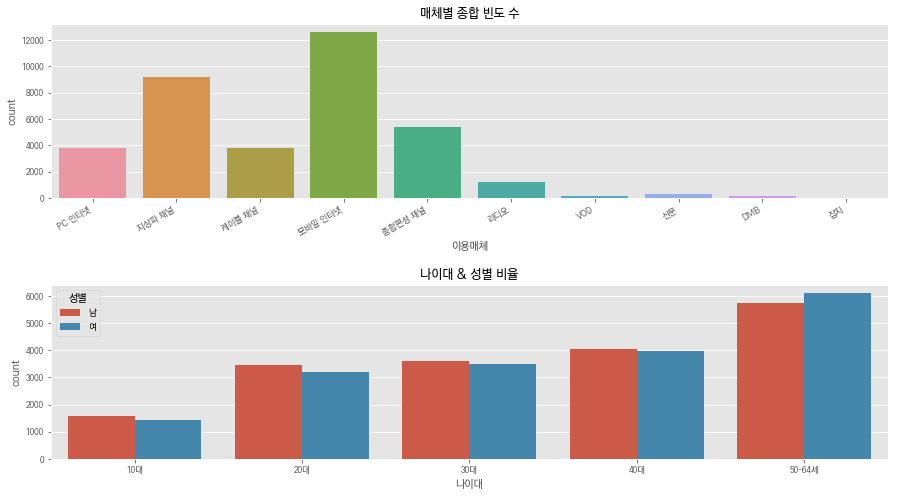

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(15, 8)
fig.subplots_adjust(hspace=0.5)

axes[0].set(title='매체별 종합 빈도 수', xlabel='매체')
axes[1].set(title='나이대 & 성별 비율', xlabel='성별')

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
sns.countplot(data=merge_df_1, x='이용매체', ax=axes[0])

sns.countplot(data=merge_df_1, x='나이대', hue='성별', ax=axes[1])

* __Note:__ 쉽게 예상할 수 있는대로 지상파 채널, 모바일 인터넷이 일반적으로 가장 큰 빈도 수를 차지한다. 하지만 특정 연령대별로 특정 시간에 다른 매체에 집중하는 경우가 있는지 발견하는 것이 목표이다.

* __Note:__ 성비가 치우치지 않아 성별을 통한 분석이 유의미할 것으로 보인다. 나이대가 높아질 수록 설문 답변율이 높다.

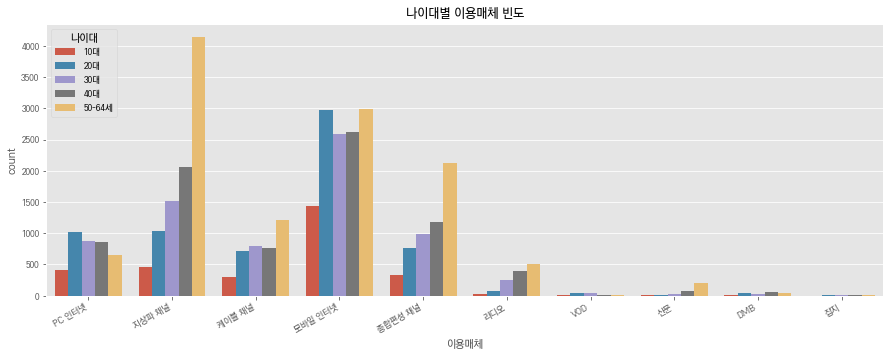

In [21]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.5)

axes.set(title='나이대별 이용매체 빈도', xlabel='매체')

plt.sca(axes)
plt.xticks(rotation=30, ha='right')
sns.countplot(data=merge_df_1, x='이용매체', hue='나이대', ax=axes)

* __Note:__ 연령대별 설문응답 총 횟수가 다르기 때문에 위와 같은 그래프는 무의미하다. 연령대를 구분하여서 시간대별, 나이대별 이용매체의 빈도를 알아볼 필요가 있다.

In [22]:
merge_df_2 = merge_df_1.copy()
merge_df_2['count'] = merge_df_2.groupby(['시간대', '나이대', '이용매체'])['고객'].transform(np.size)
merge_df_2.drop(['고객', '성별'], axis=1, inplace=True)
merge_df_2.drop_duplicates(inplace=True)

In [23]:
merge_df_2.head(5)

,나이대,시간대,이용매체,count
0,10대,10,PC 인터넷,14
1,10대,11,지상파 채널,3
2,10대,11,케이블 채널,8
3,10대,13,모바일 인터넷,111
4,10대,16,모바일 인터넷,73


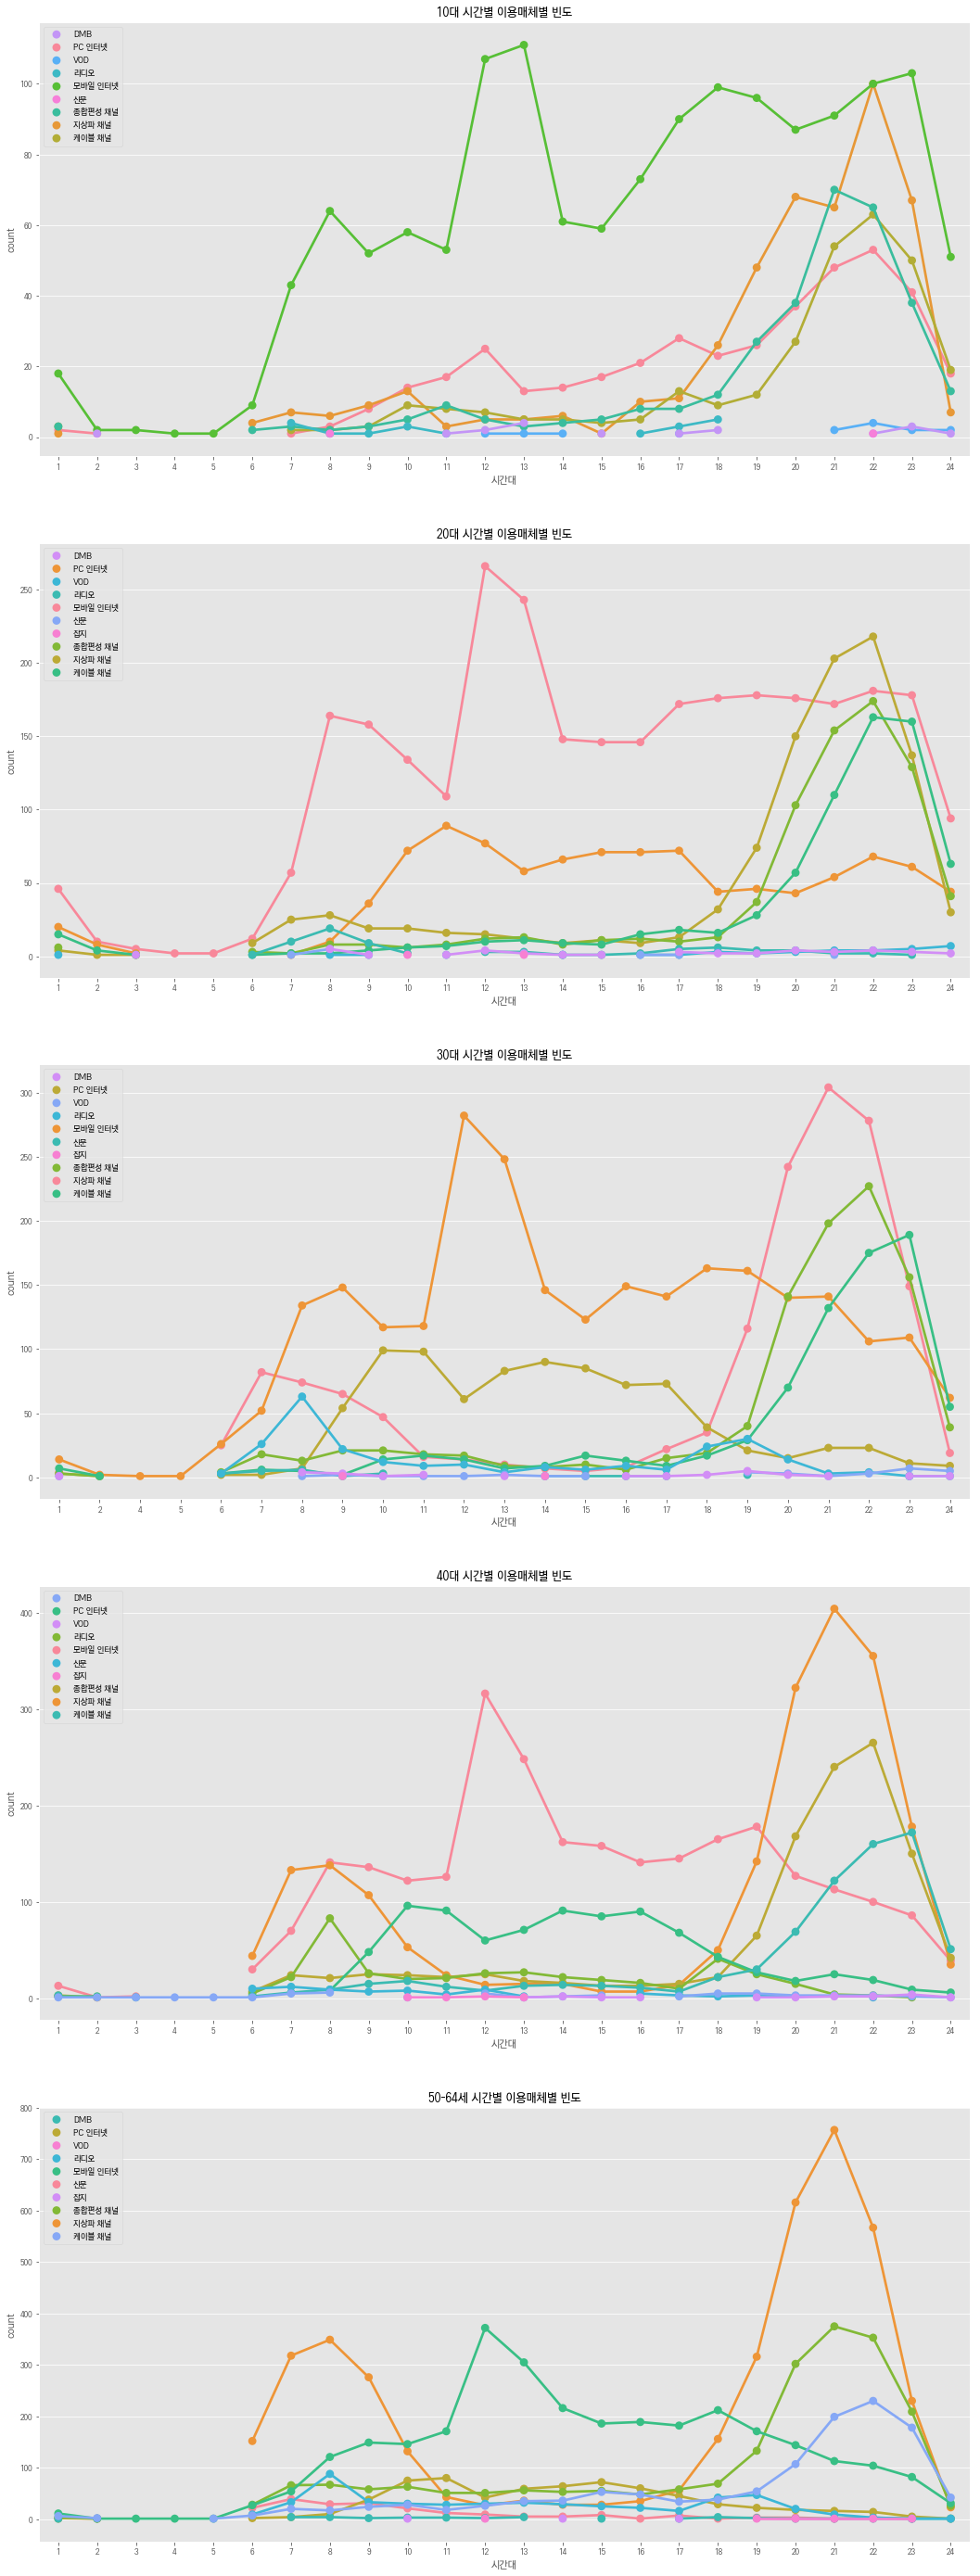

In [24]:
fig, axes = plt.subplots(nrows=5)
fig.set_size_inches(18, 50)
fig.subplots_adjust(hspace=0.2)

axes[0].set(title='10대 시간별 이용매체별 빈도', xlabel='시간대(시)')
axes[1].set(title='20대 시간별 이용매체별 빈도', xlabel='시간대(시)')
axes[2].set(title='30대 시간별 이용매체별 빈도', xlabel='시간대(시)')
axes[3].set(title='40대 시간별 이용매체별 빈도', xlabel='시간대(시)')
axes[4].set(title='50-64세 시간별 이용매체별 빈도', xlabel='시간대(시)')

sns.pointplot(data=merge_df_2[merge_df_2['나이대'] == '10대'], x='시간대', y='count', hue='이용매체', ax=axes[0])
sns.pointplot(data=merge_df_2[merge_df_2['나이대'] == '20대'], x='시간대', y='count', hue='이용매체', ax=axes[1])
sns.pointplot(data=merge_df_2[merge_df_2['나이대'] == '30대'], x='시간대', y='count', hue='이용매체', ax=axes[2])
sns.pointplot(data=merge_df_2[merge_df_2['나이대'] == '40대'], x='시간대', y='count', hue='이용매체', ax=axes[3])
sns.pointplot(data=merge_df_2[merge_df_2['나이대'] == '50-64세'], x='시간대', y='count', hue='이용매체', ax=axes[4])

for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='upper left')

## Result

* __Note:__ 모든 세대가 공통으로 모바일인터넷과 지상파 채널이 Top 2를 이루었다. 하지만 시간대에 따라 자주 이용하는 매체가 조금 씩 다르다.

* __Note:__ 10대의 경우 모든 시간대에 걸쳐서 모바일 인터넷을 가장 자주 이용하며, 다음으로 낮시간 대에는 PC인터넷, 저녁시간대에는 지상파 인터넷, 종합편성 채널을 자주 이용했다. 그 뒤를 이어 케이블 채널이 높은 빈도를 보였고 나머지는 미미하였다.

* __Note:__ 20대의 경우는 10대와 비슷한 빈도를 보였는데 10대보다 분포가 뚜렷했고,  저녁시간대(8시 이후)에는 모바일 인터넷보다 TV 채널의 의존도가 큰 것을 확인했다. 지상파 채널의 경우 모바일보다 높았고, 그 뒤를 종합편성채널, 케이블 채널이 이었다.

* __Note:__ 30대의 경우 모바일 인터넷, 지상파, 종합편성, 케이블의 순의 빈도는 10대, 20대와 비슷했으나 20대보다 저녁시간대에 TV 채널에 의존하는 경우가 더욱 많아졌다. 그리고 앞선 두 세대보다 아침 시간대, 저녁시간대에 라디오를 이용하는 빈도가 늘었다.

* __Note:__ 40대의 경우 30대와 유사하며, 다른점은 저녁시간대에 TV의 의존도 중에서도 지상파 채널의 비중이 훨씬 커졌다는 점이다. 또한 전체 시간대에서 모바일 인터넷의 비중이 많이 줄었다.

* __Note:__ 50-64세의 경우 모바일, PC 인터넷의 비중이 현저하게 줄었으며 아침시간대에서 처음으로 지상파 채널의 빈도가 모바일 인터넷을 앞서갔다. 연령대가 늘어날 수록 종합편성 채널의 빈도 또한 줄어듦을 확인하였다. 아침시간대에 라디오의 비중 또한 늘었다.

* __Note:__ 결론 - 인터넷, TV, 라디오를 제외한 매체는 이용빈도가 전체 연령대에서 빈도가 낮은 것을 확인할 수 있었는데, 신문이나 잡지의 경우 모바일, PC에서 확인할 수 있기 때문으로 보인다. 모바일의 힘이 강력한 것을 확인하였지만 연령대나 시간대에 따라 다른 매체를 통해 마케팅을 할 필요가 있다고 생각된다. 인터넷으로의 마케팅이 불가한 경우 위와 같은 분석이 도움이 될 것으로 보인다.

# Analysis 2

고객이 얼마나 광고에 집중을 하는지, 연령대 별로 고객이 집중하는 광고는 어떻게 다른지, 그에 따라 올바른 광고 마케팅을 위해서는 어떤 전략이 필요한지 데이터를 통해 결론을 도출해보는 것이 목표이다.

In [25]:
problem.loc[problem['항목명'].str.contains('주목도|관심도')].head()

,항목ID,항목명,데이터타입,설문 문항
364,C_01_012,TV 시청 중 광고 관심도,단수,귀하께서 평소 TV를 시청하실 때 광고가 나오면 광고를 얼마나 관심 있게 보십니까?
371,C_01_019,PPL(간접광고) 평가 - 제품/브랜드 관심도,단수,귀하께서는 PPL광고(간접광고)에 대해 다음의 항목별로 어떻게 생각하십니까? - 제...
378,C_01_030,드라마 PPL(간접광고) 관심도,단수,다음 각 프로그램에 나오는 PPL의 제품/서비스(장소포함)에 대해 얼마나 관심 있게...
448,C_02_035,지상파 채널 광고 주목도(1),단수,귀하께서는 평소 지상파 채널을 시청하시면서 프로그램 전/중간/후에 나오는 광고를 얼...
449,C_02_037,지상파 채널 광고 관심도,단수,귀하께서 평소 지상파 채널을 시청하실 때 광고가 나오면 광고를 얼마나 관심 있게 보...


## Preprocessing

* __Note:__ 앞서 살펴본 매체들 중에서 가장 빈도수가 높은 모바일, PC, 지상파, 종편, 케이블, 라디오에 해당하는 광고 주목도와 관심도를 합산하여 비교해본다.

In [26]:
example_dict['C_02_035']

{1: '많이 보는 편이다', 2: '어느 정도 보는 편이다', 3: '보지 않는 편이다', 4: '전혀 보지 않는다'}

In [27]:
example_dict['C_02_037']

{1: '매우 관심 있게 본다',
 2: '관심 있게 보는 편이다',
 3: '별로 관심 있게 보지 않는다',
 4: '전혀 관심 있게 보지 않는다',
 9: '무응답'}

In [28]:
example_dict['C_03_008']

{1: '많이 보는 편이다', 2: '어느 정도 보는 편이다', 3: '보지 않는 편이다', 4: '전혀 보지 않는다'}

In [29]:
example_dict['C_03_009']

{1: '매우 관심 있게 본다',
 2: '관심 있게 보는 편이다',
 3: '별로 관심 있게 보지 않는다',
 4: '전혀 관심 있게 보지 않는다'}

In [30]:
def user_interest_df():
    col = ['A_001', 'A_002', 'C_02_035', 'C_02_037', 'C_03_008', 'C_03_009', 'C_04_020', 'C_04_022', 'C_09_034', 'C_09_036', 'C_12_029', 'C_12_031', 'C_13_025', 'C_13_026']
    result_dict = defaultdict(list)
    row_count = 1
    for _, rows in answer[col].iterrows():
        user_col = 'user{}'.format(row_count)
        result_dict['고객'].append(user_col)
        col_count = 0
        for cols in col:
            col_name = problem.loc[problem['항목ID'] == cols]['항목명'].values[0]
            result_dict[col_name].append(rows[col_count])
            col_count += 1
        row_count += 1
    result_df = pd.DataFrame(result_dict)
    return result_df

def user_ad_complain_df():
    result_list = []
    df_list = []
    col = 'K_05_009#1'
    for i in range(9, 14):        
        for j in range(1, 3):
            if i < 10:
                col_str = col[:7] + '{}' + col[8:-1] + '{}'
            else:
                col_str = col[:6] + '{}' + col[8:-1] + '{}'
            result_list.append(col_str.format(i, j))
        count = 1
        col_name = problem.loc[problem['항목ID'] == result_list[0]]['항목명'].values[0]
        result_dict = defaultdict(list)
        for _, rows in answer[result_list].iterrows():            
            user_col = 'user{}'.format(count)
            each_row = rows.replace(' ', np.nan)
            each_row = each_row.dropna()
            for k in each_row.tolist():                
                result_dict['고객'].append(user_col)
                result_dict[col_name].append(k)
            count += 1
        result_list = []
        result_df = pd.DataFrame(result_dict)
        df_list.append(result_df)
    return df_list

def user_gender_age_df():
    col = ['A_001', 'A_002']
    result_df = answer[col]
    result_df.columns = ['성별', '나이대']
    result_df['고객'] = result_df.index
    result_df['고객'] = result_df['고객'].apply(lambda x: 'user{}'.format(x+1))
    return result_df

def merge_df():
    user_ad_comp_df = user_ad_complain_df()
    user_gender_df = user_gender_age_df()    
    result = []
    for df in user_ad_comp_df:
        merge_df = pd.merge(user_gender_df, df, how='inner', left_on='고객', right_on='고객')
        result.append(merge_df)
    return result

In [31]:
user_int_df = user_interest_df()

In [32]:
user_comp_df = merge_df()

In [ ]:
conf_df = user_comp_df[2]
conf_df['성별'] = conf_df['성별'].apply(cat_transform, args=('A_001',))
conf_df['나이대'] = conf_df['나이대'].apply(cat_transform, args=('A_002',))
conf_df['신뢰할 수 없는 광고 유형'] = conf_df['신뢰할 수 없는 광고 유형'].apply(cat_transform, args=('K_05_011#1',))

In [67]:
conf_df.head()

,성별,나이대,고객,신뢰할 수 없는 광고 유형
0,남,10대,user1,"마약, 규제 약물이나 물질 또는 기타 위험 품목의 광고"
1,남,10대,user1,"수술 등의 심각한 신체적 부상 또는 정서적, 정신적 피해 관련 내용, 사망 및 참사..."
2,남,10대,user2,"성 관련 제품 광고(비아그라, 성기구 등)"
3,남,10대,user2,"도발, 비하 광고(불필요한 도발, 선동, 비하를 일삼는 동영상)"
4,남,10대,user3,"성 관련 제품 광고(비아그라, 성기구 등)"


* __Note:__ 각 매체별 관심도 데이터프레임, 여러 종류의 선호하지 않는 광고에 관한 데이터프레임 리스트를 만들어 주었다.
* __Note:__ 관심도 데이터 프레임은 응답하지 않은 경우가 많이 있다. 응답 하지 않은 경우는 관심이 없다고 보고 '전혀 보지 않음' 에 해당하는 점수를 주도록 한다. 
* __Note:__ 매체별로 주목도와 관심도를 합한 점수를 최종 점수로 한다. 현재 가장 관심이 높은 정도가 1점인데 시각화를 할 때 수치로써 파악할 것이기 때문에 보다 눈에 띄게 하기 위해서 값을 반대로 바꾸어 준다.

In [33]:
user_int_df = user_int_df.replace(' ', 4)

In [34]:
def convert_rating(x):
    if x == 1:
        return 4
    if x == 2:
        return 3
    if x == 3:
        return 2
    if x == 4:
        return 1    

In [35]:
change_list = user_int_df.columns.tolist()[3:]
user_int_df[change_list] = user_int_df[change_list].applymap(convert_rating)

In [36]:
count = 0
for i in range(6):
    col_name = change_list[count].split()[0]
    user_int_df[col_name] = user_int_df[change_list[count]] + user_int_df[change_list[count+1]]
    count += 2
result_columns = ['고객', '성별', '연령(10대)', '지상파', '종편', '케이블', '라디오', 'PC', '모바일']
user_int_df = user_int_df[result_columns]

In [37]:
frame_dict = defaultdict(list)
col_list = user_int_df.columns.tolist()[3:]
for _, rows in user_int_df.iterrows():
    col_count = 3
    for cols in col_list:
        frame_dict['고객'].append(rows[0])
        frame_dict['성별'].append(rows[1])
        frame_dict['나이대'].append(rows[2])
        frame_dict['이용매체'].append(cols)
        frame_dict['점수'].append(rows[col_count])
        col_count += 1

In [39]:
user_int_dict = pd.DataFrame(frame_dict)

In [43]:
user_int_dict['성별'] = user_int_dict['성별'].apply(cat_transform, args=('A_001',))
user_int_dict['나이대'] = user_int_dict['나이대'].apply(cat_transform, args=('A_002',))

## Visualization

In [41]:
user_int_dict.columns

Index(['고객', '성별', '나이대', '이용매체', '점수'], dtype='object')

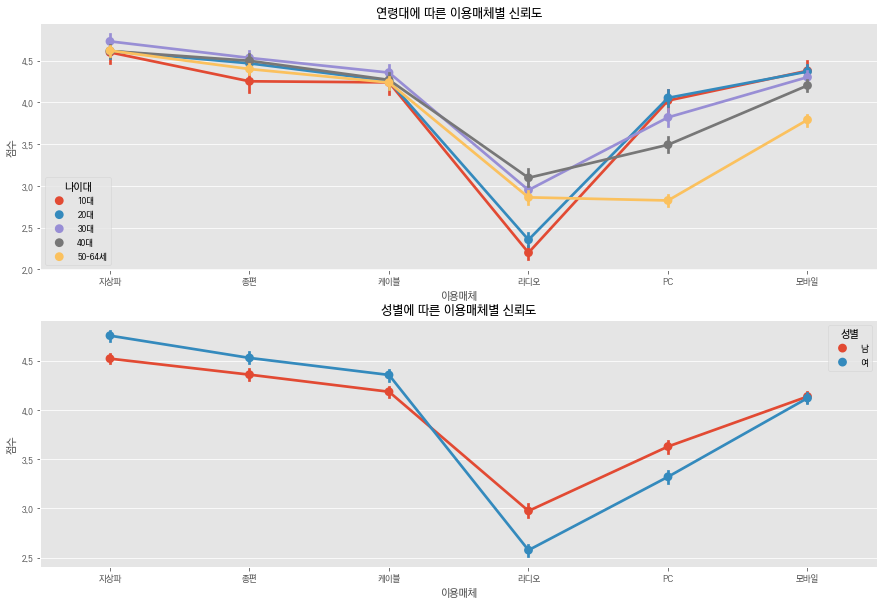

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.2)

ax[0].set(title='연령대에 따른 이용매체별 신뢰도')
ax[1].set(title='성별에 따른 이용매체별 신뢰도')

sns.pointplot(data=user_int_dict, x='이용매체', y='점수', hue='나이대', ax=ax[0])
sns.pointplot(data=user_int_dict, x='이용매체', y='점수', hue='성별', ax=ax[1])

* __Note__: 첫 번째 분석 결과 전 연령대에 걸쳐 모바일 인터넷의 의존도가 큰 것을 확인할 수 있었는데, 광고 신뢰도는 TV(지상파, 종합편성, 케이블)광고 쪽이 더 높았다. 

* __Note__: TV광고의 신뢰도는 연령대에 따라 큰 차이를 보이지 않았지만, PC나 모바일 인터넷은 연령대가 높아질 수록 신뢰도가 점점 하락하여 광고효과가 떨어질 것임을 알 수 있었다.

* __Note__: 라디오의 경우 40대에게 비교적 높은 점수를 받았다. 30대, 40대를 고려한다면 라디오 광고 또한 고려해볼만 할 것이다.

* __Note__: TV의 경우 여성이 신뢰도가 비교적 높았고, 남성이 라디오나 인터넷에서 신뢰도가 높음을 확인했다. 여성을 상대로 광고를 한다면 라디오는 좋은 선택이 아니다.

In [68]:
conf_df.columns

Index(['성별', '나이대', '고객', '신뢰할 수 없는 광고 유형'], dtype='object')

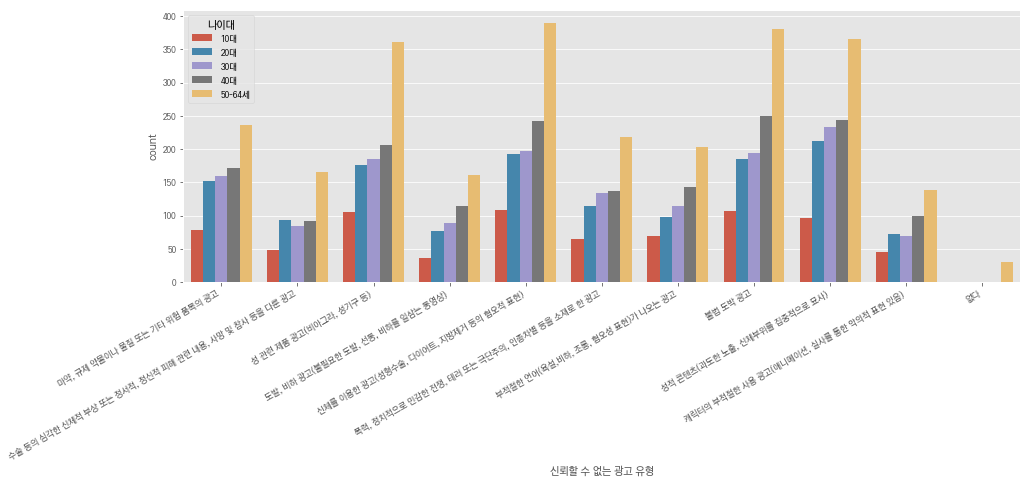

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
plt.sca(ax)
plt.xticks(rotation=30, ha='right')
sns.countplot(data=conf_df, x='신뢰할 수 없는 광고 유형', hue='나이대', ax=ax)

* __Note:__ 성별에 따른 차이가 크게 없어 통합해서 보았다. 광고를 신뢰할 수 없는 이유는 여러가지가 있는데 그 중에서도 성적인 콘텐츠나, 신체를 이용한 광고, 불법 도박과 관련된 광고가 신뢰를 떨어뜨리는 주 원인 이었다.

* __Note:__ 신뢰도는 일부 부적절한 광고 때문에 떨어지는 경우가 대부분 이었다. 신뢰도와 관련된 데이터에서는 높은 광고 효과를 내기 위한 전략을 찾기는 힘들 것 같다. 마케팅 하려는 제품에 각각에 대한 설문 데이터가 많이 존재하기 때문에 활용가능성이 충분한 데이터임을 확인하였다. 앞으로 활용도가 높을 것이다.